In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [5]:
data_dpath = r'D:\Users\Osnat\Documents\GitHub\ccpa\platedata'
csv_fnames = [ n for n in os.listdir(data_dpath) if n.endswith('.csv')]


In [6]:
def _load_plate_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    df['Sample'] = os.path.splitext(fname)[0]
    df = df.melt(id_vars=[ 'Sample', 'PRO', 'ALT', 'Day'],
        value_vars=['N', 'P', 'TMM', 'N+P+TMM', 'Control ', 'Transfer to Pro99 1:15'],
        value_name='FL',
        var_name ='Mode')
    return df

In [7]:
temp_dfs = [_load_plate_csv(data_dpath, fname) for fname in csv_fnames]
df = pd.concat(temp_dfs)
df.FL = pd.to_numeric(df.FL)
df.Day = pd.to_numeric(df.Day)
df.loc[df.FL < 100, 'FL'] = 0

In [8]:
df.shape

(20010, 6)

In [18]:
df[df.ALT.isna()]['Sample'].unique()

array(['36A', '36B'], dtype=object)

In [21]:
df = df.fillna({'ALT': 'N/A'}, )

In [9]:
df.head()

,Sample,PRO,ALT,Day,Mode,FL
0,10A,MIT0604,DE,0,N,0
1,10A,MIT0604,DE,1,N,0
2,10A,MIT0604,DE,5,N,0
3,10A,MIT0604,DE,6,N,0
4,10A,MIT0604,DE,7,N,0


In [22]:
df.dtypes

Sample    object
PRO       object
ALT       object
Day        int64
Mode      object
FL         int64
dtype: object

In [23]:
df.isna().sum()

Sample    0
PRO       0
ALT       0
Day       0
Mode      0
FL        0
dtype: int64

In [24]:
df['Mode'].unique()

array(['N', 'P', 'TMM', 'N+P+TMM', 'Control ', 'Transfer to Pro99 1:15'],
      dtype=object)

In [25]:
df['PRO'].unique()

array(['MIT0604', 'MED4', 'MIT9313', 'MIT9312', 'NATL2A', 'ALL_PRO',
       'ALL'], dtype=object)

In [26]:
df['ALT'].unique()

array(['DE', 'DE1', 'BS11', '1A3', 'ATCC', 'N/A', 'ALL'], dtype=object)

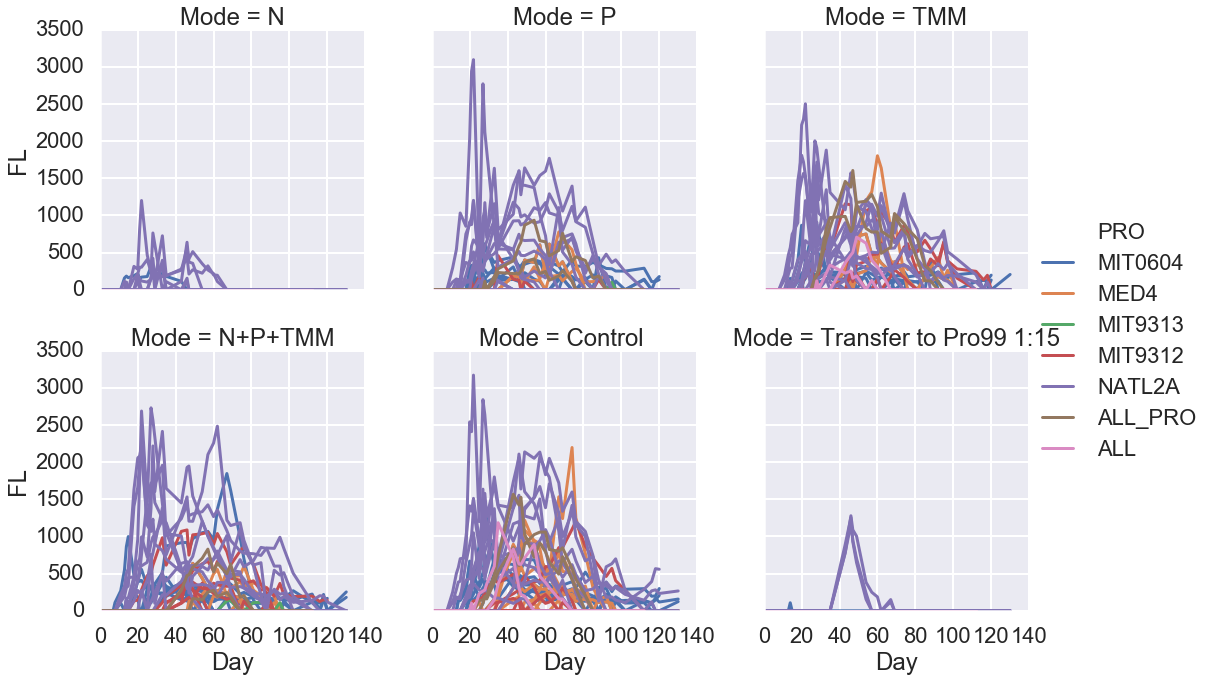

In [31]:
sns.relplot(data=df, col='Mode', hue='PRO',x='Day', y='FL', kind='line', estimator=None, units='Sample', col_wrap=3)

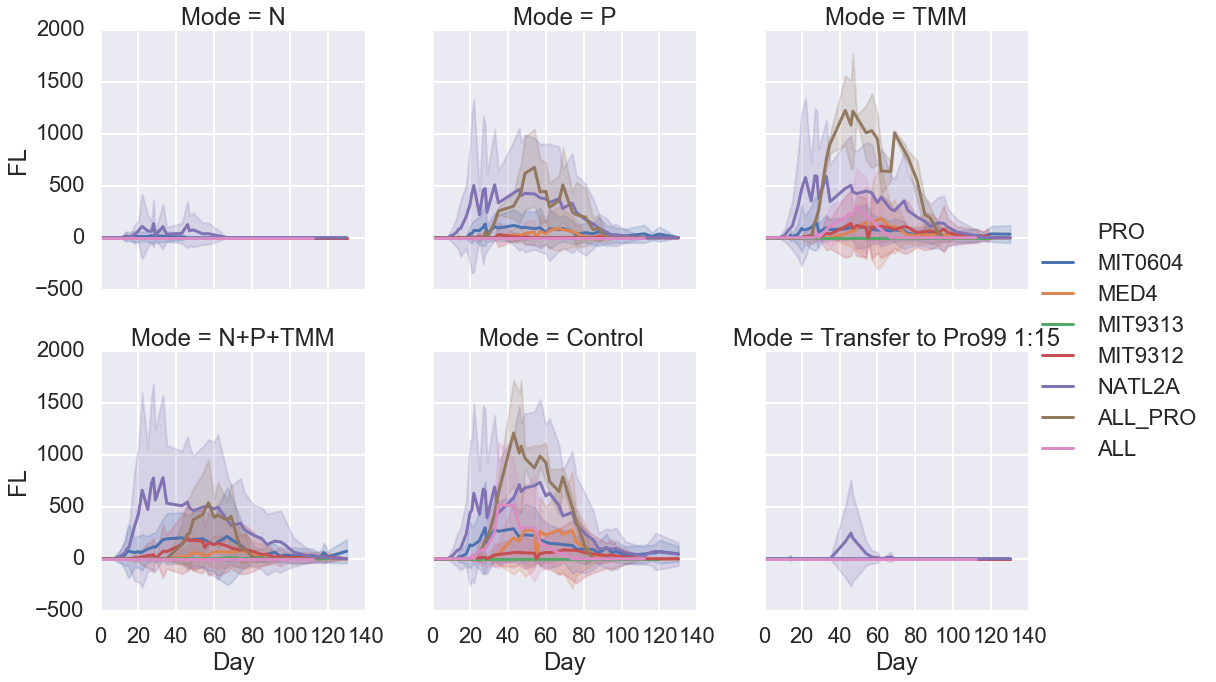

In [32]:
sns.relplot(data=df, col='Mode', hue='PRO',x='Day', y='FL', kind='line', ci='sd',col_wrap=3)

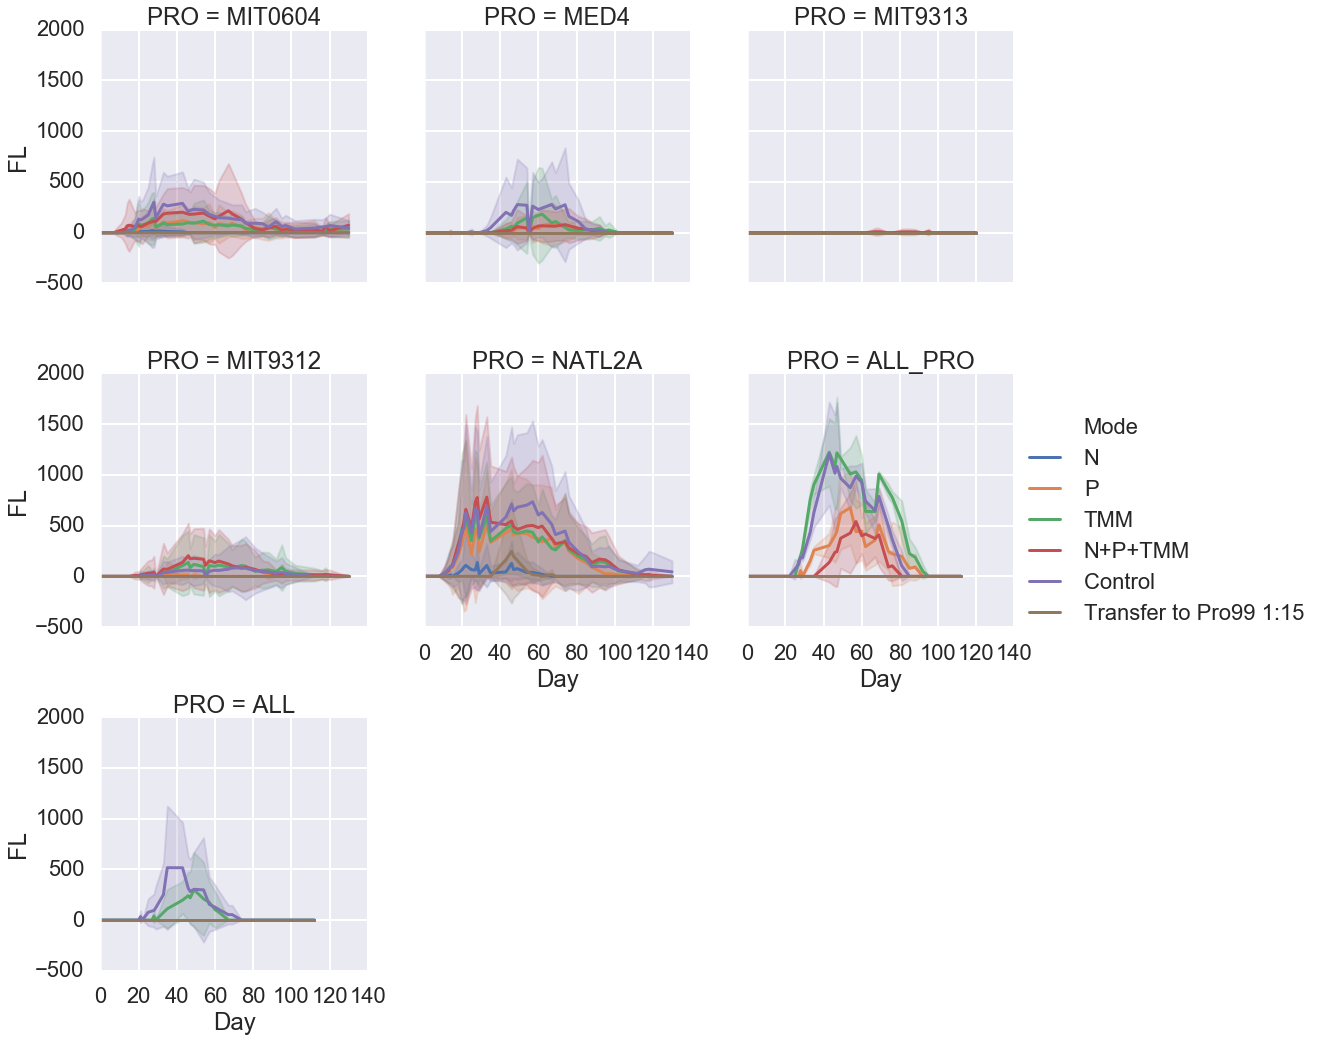

In [51]:
sns.relplot(data=df, hue='Mode', col='PRO',x='Day', y='FL', kind='line', ci='sd',col_wrap=3)

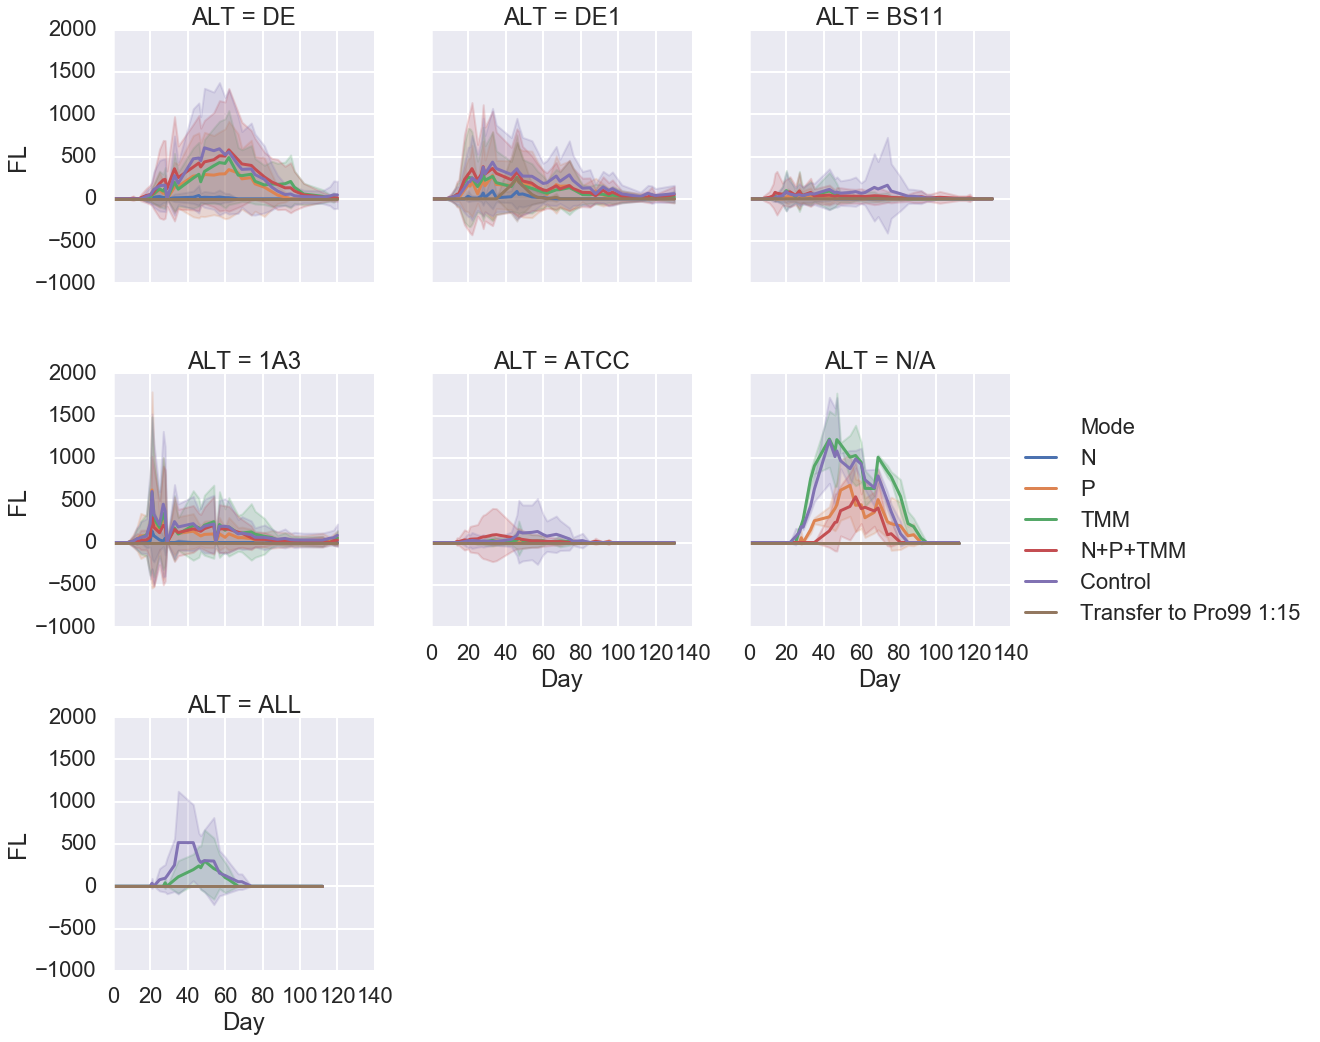

In [52]:
sns.relplot(data=df, hue='Mode', col='ALT', x='Day', y='FL', kind='line', ci='sd',col_wrap=3)

In [38]:
df.head()

,Sample,PRO,ALT,Day,Mode,FL
0,10A,MIT0604,DE,0,N,0
1,10A,MIT0604,DE,1,N,0
2,10A,MIT0604,DE,5,N,0
3,10A,MIT0604,DE,6,N,0
4,10A,MIT0604,DE,7,N,0


In [42]:
m = df.groupby(['Sample', 'PRO', 'ALT', 'Mode'])['FL'].max()
m = m.reset_index()
m.head()

,Sample,PRO,ALT,Mode,FL
0,10A,MIT0604,DE,Control,0
1,10A,MIT0604,DE,N,0
2,10A,MIT0604,DE,N+P+TMM,0
3,10A,MIT0604,DE,P,0
4,10A,MIT0604,DE,TMM,0


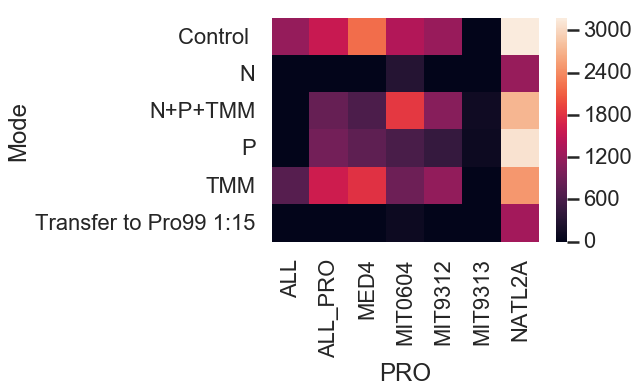

In [54]:
idx = ['PRO']
p=m.pivot_table(columns=idx, index=['Mode'], values=['FL'], aggfunc='max')
p.columns = p.columns.get_level_values(1)

sns.heatmap(p)

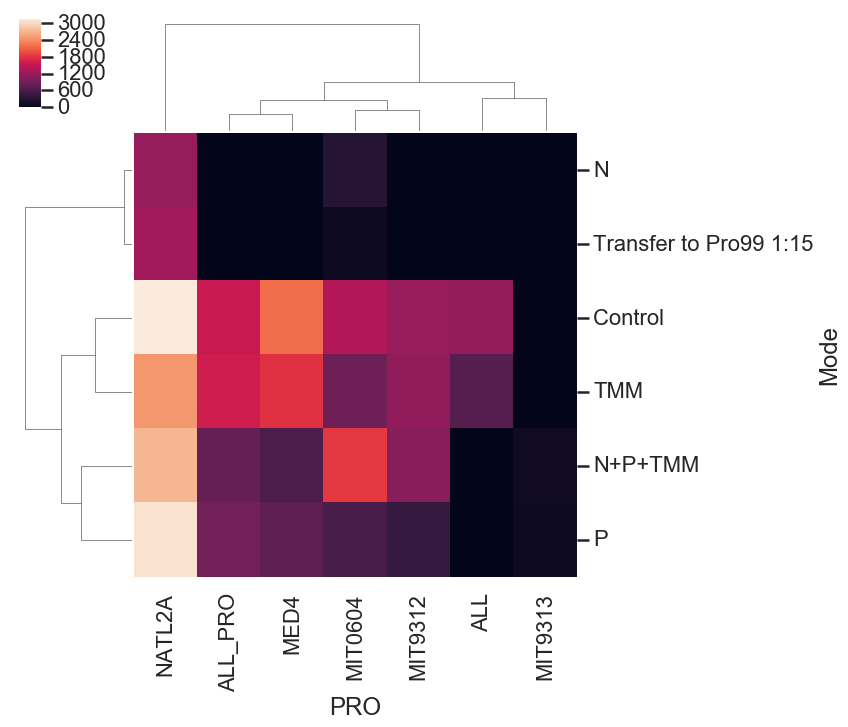

In [55]:
sns.clustermap(data=p)

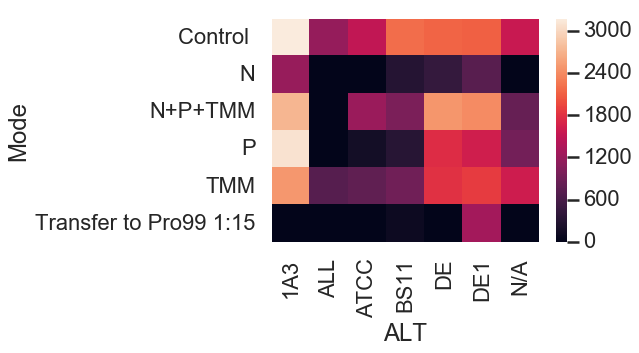

In [50]:
idx = ['ALT']
p=m.pivot_table(columns=idx, index=['Mode'], values=['FL'], aggfunc='max')
p.columns = p.columns.get_level_values(1)

sns.heatmap(p)

In [53]:
p.head()

ALT,1A3,ALL,ATCC,BS11,DE,DE1,N/A
Mode,,,,,,,
Control,3171,1185,1505,2197,2138,2109,1568
N,1201,0,0,312,439,726,0
N+P+TMM,2731,0,1221,999,2484,2414,830
P,3096,0,172,328,1769,1635,935
TMM,2502,708,783,906,1803,1879,1605


In [115]:
df = pd.read_pickle('CCPA.pkl.gz')

In [118]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [133]:
dfc = cp.update_rolling_average(dfc)
dfc.FL = dfc.roll
dfc = cp.update_calculated_fields(dfc)

ValueError: columns overlap but no suffix specified: Index(['roll'], dtype='object')

In [120]:
d = dfc.loc[dfc.experiment_sample == 'e5, 18B' ]

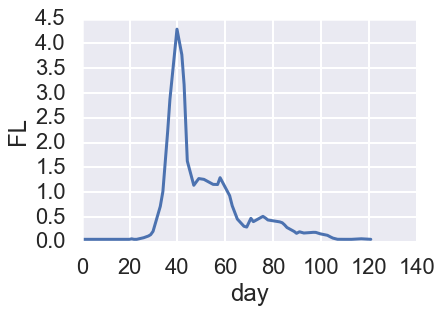

In [122]:
sns.lineplot(x = d.day, y=d.FL)

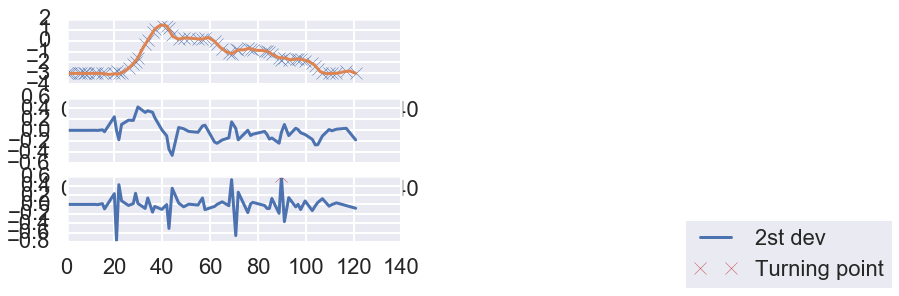

In [127]:
from scipy import interpolate
x = d.day
y = d.logFL

tck = interpolate.splrep(x, y)
xnew = np.linspace(0, np.max(x))

fig, axes = plt.subplots(3)

axes[0].plot(x, y, 'x', label = 'data')
axes[0].plot(xnew, interpolate.splev(xnew, tck, der=0), label = 'Fit')
axes[1].plot(x, interpolate.splev(x, tck, der=1), label = '1st dev')
dev_2 = interpolate.splev(x, tck, der=2)
axes[2].plot(x, dev_2, label = '2st dev')

turning_point_mask = dev_2 == np.amax(dev_2)
axes[2].plot(x[turning_point_mask], dev_2[turning_point_mask],'rx',
             label = 'Turning point')
plt.legend(loc = 'best', bbox_to_anchor=(0.5, 0., 2, 0.5))
plt.show()


In [128]:
d.loc[:,'dev2'] = dev_2

In [132]:
tck

(array([  0.  ,   0.  ,   0.  ,   0.  ,   1.92,   5.11,   5.91,   7.1 ,
          7.86,   8.8 ,  11.88,  12.89,  14.99,  15.87,  19.97,  20.88,
         21.87,  23.  ,  25.9 ,  27.91,  28.84,  29.83,  32.86,  33.95,
         35.94,  36.89,  39.84,  41.87,  42.82,  44.16,  46.87,  48.95,
         51.1 ,  54.95,  56.83,  57.87,  61.86,  62.94,  65.08,  67.85,
         69.01,  70.75,  71.78,  75.78,  76.94,  77.86,  82.79,  83.85,
         84.82,  85.84,  88.86,  89.84,  91.08,  92.9 ,  95.81,  96.8 ,
         97.87,  99.74, 102.75, 104.03, 105.07, 106.98, 109.77, 110.92,
        112.85, 120.9 , 120.9 , 120.9 , 120.9 ]),
 array([-2.99573227, -2.99573222, -2.99573251, -2.99573147, -2.99573305,
        -2.99572829, -2.99574209, -2.99563885, -2.99661039, -2.99439545,
        -3.00448487, -2.96575434, -3.40181863, -2.69752909, -3.08219527,
        -2.97363163, -2.53461674, -2.2162053 , -1.96835786, -1.28037711,
        -0.501814  ,  0.07091205,  0.73443296,  1.22927877,  1.55863288,
         

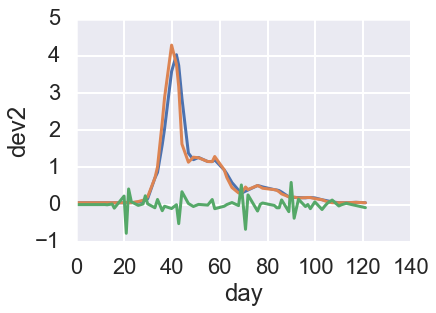

In [131]:
sns.lineplot(x=d.day, y=d.roll)
sns.lineplot(x=d.day, y=d.FL)
sns.lineplot(x=d.day, y=d.dev2)


In [57]:
d.index = d.day

In [65]:
d.FL.rolling(3).mean()

day
0.00           NaN
0.88           NaN
1.92      0.050000
5.11      0.050000
5.91      0.050000
7.10      0.050000
7.86      0.050000
8.80      0.050000
11.88     0.050000
12.89     0.050000
14.99     0.050000
15.87     0.050000
19.97     0.050000
20.88     0.053333
21.87     0.053333
23.00     0.053333
25.90     0.060667
27.91     0.083000
28.84     0.114333
29.83     0.157000
32.86     0.356000
33.95     0.646000
35.94     1.315667
36.89     2.034667
39.84     3.125667
41.87     3.643333
42.82     3.743000
44.16     2.856667
46.87     1.979000
48.95     1.347333
            ...   
62.94     0.983667
65.08     0.705333
67.85     0.499333
69.01     0.356000
70.75     0.361000
71.78     0.392000
75.78     0.464000
76.94     0.465000
77.86     0.476333
82.79     0.439333
83.85     0.408667
84.82     0.376000
85.84     0.338000
88.86     0.279333
89.84     0.222333
91.08     0.193667
92.90     0.183333
95.81     0.188667
96.80     0.185000
97.87     0.189333
99.74     0.180667
102.75  